In [1]:
import wfcommons.wfchef.utils as utils

from QHyper.problems.algorithms.utils import wfworkflow_to_qhyper_workflow, merge_subworkflows
from QHyper.problems.algorithms.workflow_decomposition import HeftBasedAlgorithm
from QHyper.problems.workflow_scheduling import Workflow, WorkflowSchedulingProblem
from QHyper.solvers.cqm import CQM


## Load and divide workflow

In [2]:
tasks_file = "workflows_data/workflows/complex_workflow.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 50

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

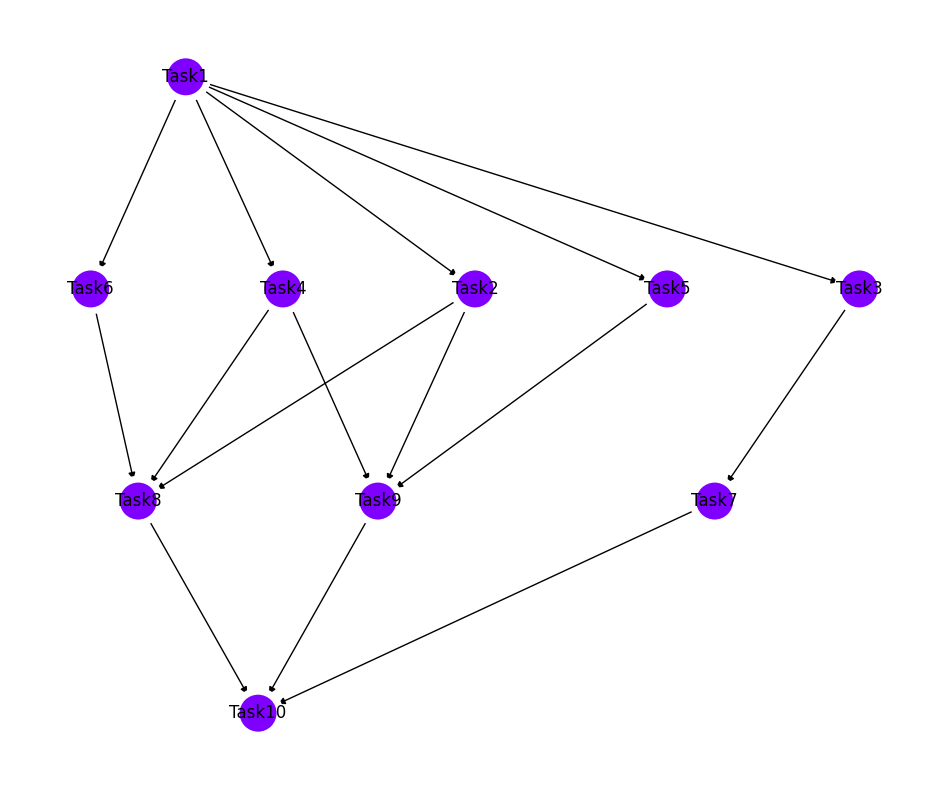

In [3]:
workflow = Workflow(tasks_file, machines_file, deadline)
utils.draw(workflow.wf_instance.workflow, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

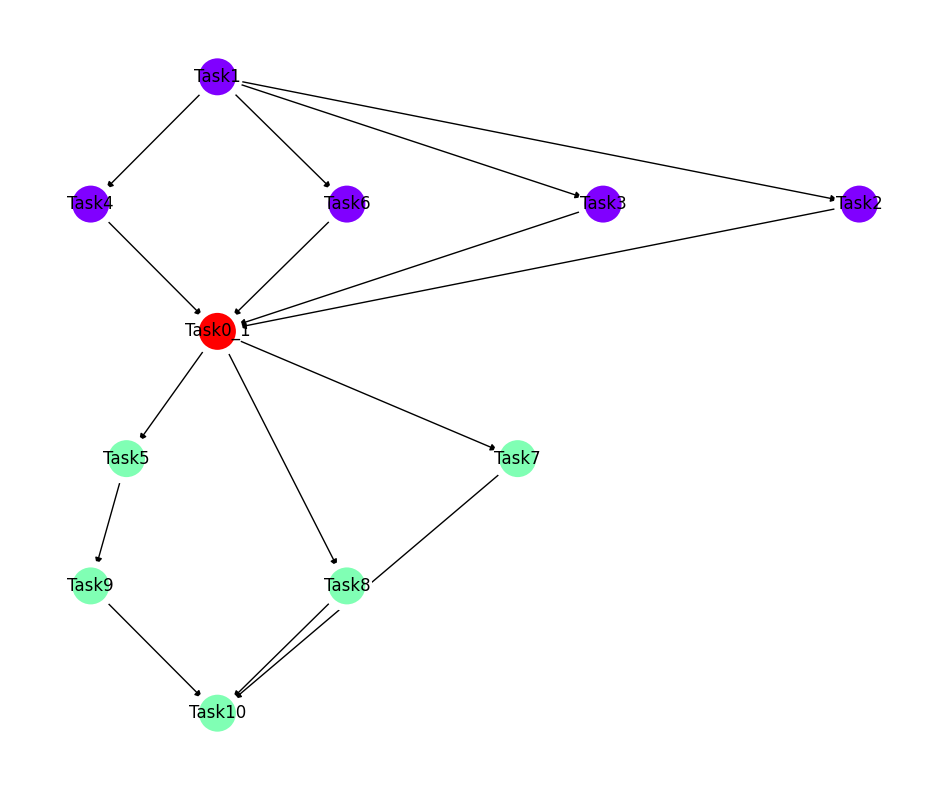

In [4]:
wf_workflow1, wf_workflow2 = HeftBasedAlgorithm().decompose(workflow, 2)
merged = merge_subworkflows([wf_workflow1, wf_workflow2])
utils.draw(merged, with_labels=True)

In [5]:
workflow1 = wfworkflow_to_qhyper_workflow(wf_workflow1, machines_file, deadline / 2)
workflow2 = wfworkflow_to_qhyper_workflow(wf_workflow2, machines_file, deadline / 2)
wsp1 = WorkflowSchedulingProblem(workflow1)
wsp2 = WorkflowSchedulingProblem(workflow2)

## Solve the Workflow Schedluling Problem with the CQM solver.

In [6]:
cqm1 = CQM(problem=wsp1, time=5)
cqm2 = CQM(problem=wsp2, time=5)

solution_cqm1 = cqm1.solve()
solution_cqm2 = cqm2.solve()

In [8]:
solution1 = wsp1.decode_solution(solution_cqm1)
solution2 = wsp2.decode_solution(solution_cqm2)

print(f"Task assignment for first subgraph: {solution1}")
print(f"Task assignment for second subgraph: {solution2}")

Task assignment for first subgraph: {'Task1': 'MachineA', 'Task4': 'MachineA', 'Task2': 'MachineA', 'Task0_1': 'MachineA', 'Task6': 'MachineA', 'Task3': 'MachineA'}
Task assignment for second subgraph: {'Task5': 'MachineA', 'Task8': 'MachineA', 'Task10': 'MachineA', 'Task0_1': 'MachineA', 'Task9': 'MachineB', 'Task7': 'MachineA'}


In [9]:
cost1 = wsp1.calculate_solution_cost(solution1)
time1 = wsp1.calculate_solution_timespan(solution1)
print(f"Cost of running first subworkflow: {cost1}")
print(f"Time of running first subworkflow: {time1}")

cost2 = wsp2.calculate_solution_cost(solution2)
time2 = wsp2.calculate_solution_timespan(solution2)
print(f"Cost of running second subworkflow: {cost2}")
print(f"Time of running second subworkflow: {time2}")

print(f"Cost of running full workflow: {cost1 + cost2}")
print(f"Time of running full workflow: {time1 + time2}")

Cost of running first subworkflow: 27.0
Time of running first subworkflow: 9.0
Cost of running second subworkflow: 48.0
Time of running second subworkflow: 21.0
Cost of running full workflow: 75.0
Time of running full workflow: 30.0


## Version without split on CQM

In [11]:
wsp = WorkflowSchedulingProblem(workflow)
cqm = CQM(problem=wsp, time=5)
solution_cqm = cqm.solve()

In [12]:
solution = wsp.decode_solution(solution_cqm)
print(f"Task assignment for full graph: {solution}")

Task assignment for full graph: {'Task1': 'MachineA', 'Task2': 'MachineA', 'Task5': 'MachineA', 'Task6': 'MachineA', 'Task7': 'MachineA', 'Task8': 'MachineA', 'Task9': 'MachineA', 'Task10': 'MachineA', 'Task3': 'MachineA', 'Task4': 'MachineA'}


In [41]:
cost = wsp.calculate_solution_cost(solution)
time = wsp.calculate_solution_timespan(solution)
print(f"Cost of running full workflow: {cost}")
print(f"Time of running full workflow: {time}")

Cost of running full workflow: 72.0
Time of running full workflow: 30.0


## Save results as reports

In [1]:
from reports.report import ExecutionReport, Division, Subworkflow, Solution, WorkflowSolution

In [39]:
with_division_report = ExecutionReport(
    workflow=tasks_file,
    machines=machines_file,
    deadline=deadline,
    division=Division(
        method="HeftBasedAlgorithm",
        workflows=[
            Subworkflow(id=0,deadline=workflow1.deadline,workflow=workflow1),
            Subworkflow(id=1,deadline=workflow2.deadline,workflow=workflow2)
        ]
    ),
    solution=Solution(
        solver="CQM",
        workflows=[
            WorkflowSolution(id=0,machine_assignment=solution1,cost=cost1,time=time1),
            WorkflowSolution(id=1,machine_assignment=solution2,cost=cost2,time=time2)
        ],
        cost=cost1+cost2,
        time=time1+time2
    )
)

In [40]:
with_division_report.write_json("reports/cqm_division_12_12_23.json")

In [42]:
without_division_report = ExecutionReport(
    workflow=tasks_file,
    machines=machines_file,
    deadline=deadline,
    division=Division(
        method="HeftBasedAlgorithm",
        workflows=[
            Subworkflow(id=0,deadline=workflow.deadline,workflow=workflow)
        ]
    ),
    solution=Solution(
        solver="CQM",
        workflows=[
            WorkflowSolution(id=0,machine_assignment=solution,cost=cost,time=time)
        ],
        cost=cost,
        time=time
    )
)

In [43]:
without_division_report.write_json("reports/cqm_no_division_12_12_23.json")